# Model building / selection

We will now look at building/selecting our models, as we have a classifcation task (predicting 0 or 1) we will compare a verity of classifcation algorithms like
* Random Forest
* Gradient boosting machines
* Adaboost 
* Logistic regression

and so on.

As we are interested in roc_auc scores we will predict probabilities from our models.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import warnings 
warnings.filterwarnings("ignore")

DATA_DIR = "../Data/"

In [37]:
train_data = pd.read_csv(DATA_DIR + "processed_train.csv")
test_data = pd.read_csv(DATA_DIR + "processed_test.csv")

We will now make a function for easily testing different models.

In [38]:
def train_and_test_model(train_data : pd.DataFrame,  
                         model, 
                         print_info : bool= True,
                         **model_paramaters):
    '''
    Function for fitting data to a model using stratified k fold with 10 folds.
    Args:
    train_data (pd.DataFrame)
    test_data (pd.DataFrame)
    model (sklearn style model)
    model_paramaters (dictionary)
    '''
    # Get training data
    X_train = train_data.drop("loan_status", axis = 1)
    # Get labels
    y_train = train_data["loan_status"]
    # Set paramaters
    model.set_params(**model_paramaters)
    # Create folds
    strat_k_fold = StratifiedKFold(10, shuffle= True)
    # Create auc score lists
    train_auc_scores = []
    val_auc_scores = []#
    val_acc_scores = []
    # Loop through folds in folded data.
    for fold , (train_ind, val_inx) in enumerate(strat_k_fold.split(X_train, y_train), 1):
        x_train_fold, x_val_fold = X_train.iloc[train_ind], X_train.iloc[val_inx]
        y_train_fold, y_val_fold = y_train.iloc[train_ind], y_train.iloc[val_inx]

        model.fit(x_train_fold, y_train_fold)

        y_train_pred = model.predict_proba(x_train_fold)[:, 1]
        
        train_auc = roc_auc_score(y_train_fold, y_train_pred)

        train_auc_scores.append(train_auc)

        y_val_pred = model.predict_proba(x_val_fold)[:, 1]
        y_val_label_pred = model.predict(x_val_fold)
        val_auc = roc_auc_score(y_val_fold, y_val_pred)
        val_acc_scores.append(accuracy_score(y_val_label_pred, y_val_fold))
        val_auc_scores.append(val_auc)
        if print_info:
            print(f"Fold {fold}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")
            
    mean_train_auc = np.mean(train_auc_scores)
    mean_val_auc = np.mean(val_auc_scores)
    mean_val_acc = np.mean(val_acc_scores)
    if print_info:
        print(f"\nMean Train AUC: {mean_train_auc:.4f}")
        print(f"Mean Validation AUC: {mean_val_auc:.4f}")
        print(f'Mean accuracy {mean_val_acc}')
    return mean_val_auc

We will train our model using 10 stratified Kfolds on our training data, using the mean validation ROC AUC as our model comparison criteria. First we will just test our models with no hyperparamaters tuning to see which one does the best oob, and hyperparamater tune that model from there.

In [4]:
models = [xgb.XGBClassifier(),
          RandomForestClassifier(),
          KNeighborsClassifier(5),
          GradientBoostingClassifier(),
          LogisticRegression(),
          BaggingClassifier()
 ]




model_names = []
model_val_roc = []


for model in models:
    val_roc_auc = train_and_test_model(train_data, model, print_info = True)

    model_names.append(type(model).__name__)
    model_val_roc.append(val_roc_auc)

Fold 1: Train AUC = 0.9890, Validation AUC = 0.9458
Fold 2: Train AUC = 0.9892, Validation AUC = 0.9533
Fold 3: Train AUC = 0.9896, Validation AUC = 0.9523
Fold 4: Train AUC = 0.9885, Validation AUC = 0.9540
Fold 5: Train AUC = 0.9890, Validation AUC = 0.9508
Fold 6: Train AUC = 0.9899, Validation AUC = 0.9550
Fold 7: Train AUC = 0.9893, Validation AUC = 0.9514
Fold 8: Train AUC = 0.9888, Validation AUC = 0.9564
Fold 9: Train AUC = 0.9888, Validation AUC = 0.9556
Fold 10: Train AUC = 0.9887, Validation AUC = 0.9570

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9532
Mean accuracy 0.9509592915403304
Fold 1: Train AUC = 1.0000, Validation AUC = 0.9252
Fold 2: Train AUC = 1.0000, Validation AUC = 0.9377
Fold 3: Train AUC = 1.0000, Validation AUC = 0.9346
Fold 4: Train AUC = 1.0000, Validation AUC = 0.9367
Fold 5: Train AUC = 1.0000, Validation AUC = 0.9363
Fold 6: Train AUC = 1.0000, Validation AUC = 0.9342
Fold 7: Train AUC = 1.0000, Validation AUC = 0.9345
Fold 8: Train AUC = 1.0000, Va

In [5]:
model_pred = pd.DataFrame({"Model" : model_names, "VAL_ROC" :model_val_roc} )
model_pred.sort_values(by="VAL_ROC", ascending= False)

,Model,VAL_ROC
0,XGBClassifier,0.953158
3,GradientBoostingClassifier,0.940072
1,RandomForestClassifier,0.934865
5,BaggingClassifier,0.912601
4,LogisticRegression,0.844166
2,KNeighborsClassifier,0.731539


We see that our XGBclassifer does significantly better OOB then the others do. So we will now tune XGBclassifier from here to achieve the highest auc roc possible.

To do so we will make use of optuna optimisation.

In [6]:
import optuna 

def objective(trial):

    xgboost_params = {
        "objective" : "binary:logistic",
        "eval_metric" : "auc",
        "device" : "cuda",
        "eta" : trial.suggest_loguniform("eta", 1e-4, 1 ),
        "alpha" : trial.suggest_loguniform("alpha", 1e-3, 10),
        "num_leaves" : trial.suggest_categorical("num_leaves", [10,20,30,40,50,70, 100]),
        "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-4, 1),
        "max_depth" : trial.suggest_categorical("max_depth", [5,7,9,11,13]),
        "n_estimators" : trial.suggest_categorical("n_estimators" , [10, 20, 50, 100, 500, 1000])
    }
    model = xgb.XGBClassifier()
    auc = train_and_test_model(train_data, model, print = False, model_paramaters= xgboost_params)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 30)




[I 2024-10-18 17:23:45,576] A new study created in memory with name: no-name-645081e7-0034-42ae-8653-f8c02c135f34


Fold 1: Train AUC = 0.9895, Validation AUC = 0.9502
Fold 2: Train AUC = 0.9899, Validation AUC = 0.9519
Fold 3: Train AUC = 0.9890, Validation AUC = 0.9505
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9526
Fold 5: Train AUC = 0.9889, Validation AUC = 0.9520
Fold 6: Train AUC = 0.9888, Validation AUC = 0.9597
Fold 7: Train AUC = 0.9891, Validation AUC = 0.9466
Fold 8: Train AUC = 0.9888, Validation AUC = 0.9548
Fold 9: Train AUC = 0.9894, Validation AUC = 0.9523


[I 2024-10-18 17:23:49,387] Trial 0 finished with value: 0.9530358468637287 and parameters: {'eta': 0.00025289886804365696, 'alpha': 7.701298081784142, 'num_leaves': 70, 'learning_rate': 0.9757345147464512, 'max_depth': 9, 'n_estimators': 20}. Best is trial 0 with value: 0.9530358468637287.


Fold 10: Train AUC = 0.9886, Validation AUC = 0.9597

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9530
Mean accuracy 0.9506694422831117
Fold 1: Train AUC = 0.9887, Validation AUC = 0.9523
Fold 2: Train AUC = 0.9895, Validation AUC = 0.9571
Fold 3: Train AUC = 0.9888, Validation AUC = 0.9502
Fold 4: Train AUC = 0.9892, Validation AUC = 0.9501
Fold 5: Train AUC = 0.9895, Validation AUC = 0.9554
Fold 6: Train AUC = 0.9881, Validation AUC = 0.9571
Fold 7: Train AUC = 0.9895, Validation AUC = 0.9407
Fold 8: Train AUC = 0.9896, Validation AUC = 0.9498
Fold 9: Train AUC = 0.9892, Validation AUC = 0.9543


[I 2024-10-18 17:23:53,336] Trial 1 finished with value: 0.9522938482852716 and parameters: {'eta': 0.0023334709452005613, 'alpha': 0.04763294810937987, 'num_leaves': 70, 'learning_rate': 0.025777330646205625, 'max_depth': 5, 'n_estimators': 10}. Best is trial 0 with value: 0.9530358468637287.


Fold 10: Train AUC = 0.9876, Validation AUC = 0.9559

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9523
Mean accuracy 0.9510786000146544
Fold 1: Train AUC = 0.9888, Validation AUC = 0.9490
Fold 2: Train AUC = 0.9893, Validation AUC = 0.9554
Fold 3: Train AUC = 0.9893, Validation AUC = 0.9548
Fold 4: Train AUC = 0.9897, Validation AUC = 0.9492
Fold 5: Train AUC = 0.9890, Validation AUC = 0.9462
Fold 6: Train AUC = 0.9890, Validation AUC = 0.9584
Fold 7: Train AUC = 0.9889, Validation AUC = 0.9521
Fold 8: Train AUC = 0.9892, Validation AUC = 0.9510
Fold 9: Train AUC = 0.9893, Validation AUC = 0.9524


[I 2024-10-18 17:23:56,996] Trial 2 finished with value: 0.9521830840536089 and parameters: {'eta': 0.15201792893105964, 'alpha': 0.0032561292446866177, 'num_leaves': 20, 'learning_rate': 0.09908876702529865, 'max_depth': 5, 'n_estimators': 1000}. Best is trial 0 with value: 0.9530358468637287.


Fold 10: Train AUC = 0.9882, Validation AUC = 0.9534

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9522
Mean accuracy 0.9507886460830255
Fold 1: Train AUC = 0.9891, Validation AUC = 0.9541
Fold 2: Train AUC = 0.9898, Validation AUC = 0.9516
Fold 3: Train AUC = 0.9887, Validation AUC = 0.9524
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9526
Fold 5: Train AUC = 0.9883, Validation AUC = 0.9488
Fold 6: Train AUC = 0.9892, Validation AUC = 0.9484
Fold 7: Train AUC = 0.9890, Validation AUC = 0.9489
Fold 8: Train AUC = 0.9896, Validation AUC = 0.9574
Fold 9: Train AUC = 0.9888, Validation AUC = 0.9526


[I 2024-10-18 17:24:00,449] Trial 3 finished with value: 0.9518557599385072 and parameters: {'eta': 0.03992999076347032, 'alpha': 0.6804245623450539, 'num_leaves': 20, 'learning_rate': 0.002692724716967996, 'max_depth': 13, 'n_estimators': 50}. Best is trial 0 with value: 0.9530358468637287.


Fold 10: Train AUC = 0.9889, Validation AUC = 0.9518

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9519
Mean accuracy 0.9506182681269909
Fold 1: Train AUC = 0.9903, Validation AUC = 0.9432
Fold 2: Train AUC = 0.9882, Validation AUC = 0.9574
Fold 3: Train AUC = 0.9893, Validation AUC = 0.9586
Fold 4: Train AUC = 0.9892, Validation AUC = 0.9555
Fold 5: Train AUC = 0.9893, Validation AUC = 0.9539
Fold 6: Train AUC = 0.9890, Validation AUC = 0.9522
Fold 7: Train AUC = 0.9891, Validation AUC = 0.9561
Fold 8: Train AUC = 0.9893, Validation AUC = 0.9569
Fold 9: Train AUC = 0.9887, Validation AUC = 0.9508


[I 2024-10-18 17:24:03,878] Trial 4 finished with value: 0.953046253833455 and parameters: {'eta': 0.00022712757691586202, 'alpha': 0.011621443692431059, 'num_leaves': 70, 'learning_rate': 0.2816268109315556, 'max_depth': 9, 'n_estimators': 1000}. Best is trial 4 with value: 0.953046253833455.


Fold 10: Train AUC = 0.9892, Validation AUC = 0.9459

Mean Train AUC: 0.9892
Mean Validation AUC: 0.9530
Mean accuracy 0.9510614857485791
Fold 1: Train AUC = 0.9882, Validation AUC = 0.9558
Fold 2: Train AUC = 0.9897, Validation AUC = 0.9562
Fold 3: Train AUC = 0.9900, Validation AUC = 0.9564
Fold 4: Train AUC = 0.9895, Validation AUC = 0.9558
Fold 5: Train AUC = 0.9888, Validation AUC = 0.9535
Fold 6: Train AUC = 0.9896, Validation AUC = 0.9510
Fold 7: Train AUC = 0.9882, Validation AUC = 0.9545
Fold 8: Train AUC = 0.9898, Validation AUC = 0.9457
Fold 9: Train AUC = 0.9896, Validation AUC = 0.9476


[I 2024-10-18 17:24:07,272] Trial 5 finished with value: 0.9532683286736336 and parameters: {'eta': 0.9672022809038247, 'alpha': 0.5913041226946202, 'num_leaves': 100, 'learning_rate': 0.009933782296895595, 'max_depth': 7, 'n_estimators': 1000}. Best is trial 5 with value: 0.9532683286736336.


Fold 10: Train AUC = 0.9888, Validation AUC = 0.9562

Mean Train AUC: 0.9892
Mean Validation AUC: 0.9533
Mean accuracy 0.9511296782192323
Fold 1: Train AUC = 0.9884, Validation AUC = 0.9584
Fold 2: Train AUC = 0.9897, Validation AUC = 0.9453
Fold 3: Train AUC = 0.9888, Validation AUC = 0.9517
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9582
Fold 5: Train AUC = 0.9891, Validation AUC = 0.9491
Fold 6: Train AUC = 0.9886, Validation AUC = 0.9443
Fold 7: Train AUC = 0.9894, Validation AUC = 0.9579
Fold 8: Train AUC = 0.9890, Validation AUC = 0.9485
Fold 9: Train AUC = 0.9880, Validation AUC = 0.9563


[I 2024-10-18 17:24:10,638] Trial 6 finished with value: 0.9519567279460445 and parameters: {'eta': 0.00028843083848223867, 'alpha': 0.021532933012979094, 'num_leaves': 100, 'learning_rate': 0.009549354669227307, 'max_depth': 9, 'n_estimators': 10}. Best is trial 5 with value: 0.9532683286736336.


Fold 10: Train AUC = 0.9893, Validation AUC = 0.9499

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9520
Mean accuracy 0.9509422034428576
Fold 1: Train AUC = 0.9882, Validation AUC = 0.9582
Fold 2: Train AUC = 0.9900, Validation AUC = 0.9434
Fold 3: Train AUC = 0.9884, Validation AUC = 0.9499
Fold 4: Train AUC = 0.9891, Validation AUC = 0.9545
Fold 5: Train AUC = 0.9885, Validation AUC = 0.9563
Fold 6: Train AUC = 0.9897, Validation AUC = 0.9497
Fold 7: Train AUC = 0.9899, Validation AUC = 0.9452
Fold 8: Train AUC = 0.9893, Validation AUC = 0.9533
Fold 9: Train AUC = 0.9889, Validation AUC = 0.9537


[I 2024-10-18 17:24:14,059] Trial 7 finished with value: 0.9523040354207641 and parameters: {'eta': 0.07385974547439557, 'alpha': 0.18550693250120212, 'num_leaves': 50, 'learning_rate': 0.001455498699300626, 'max_depth': 7, 'n_estimators': 500}. Best is trial 5 with value: 0.9532683286736336.


Fold 10: Train AUC = 0.9884, Validation AUC = 0.9588

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9523
Mean accuracy 0.9508739557273765
Fold 1: Train AUC = 0.9892, Validation AUC = 0.9539
Fold 2: Train AUC = 0.9885, Validation AUC = 0.9586
Fold 3: Train AUC = 0.9883, Validation AUC = 0.9619
Fold 4: Train AUC = 0.9889, Validation AUC = 0.9511
Fold 5: Train AUC = 0.9903, Validation AUC = 0.9461
Fold 6: Train AUC = 0.9887, Validation AUC = 0.9553
Fold 7: Train AUC = 0.9889, Validation AUC = 0.9535
Fold 8: Train AUC = 0.9886, Validation AUC = 0.9491
Fold 9: Train AUC = 0.9885, Validation AUC = 0.9495


[I 2024-10-18 17:24:17,488] Trial 8 finished with value: 0.953312574295429 and parameters: {'eta': 0.00016717230341957513, 'alpha': 0.04505301724660733, 'num_leaves': 20, 'learning_rate': 0.003770945640139732, 'max_depth': 11, 'n_estimators': 50}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9892, Validation AUC = 0.9541

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9533
Mean accuracy 0.9512148860967959
Fold 1: Train AUC = 0.9884, Validation AUC = 0.9583
Fold 2: Train AUC = 0.9880, Validation AUC = 0.9570
Fold 3: Train AUC = 0.9894, Validation AUC = 0.9514
Fold 4: Train AUC = 0.9889, Validation AUC = 0.9513
Fold 5: Train AUC = 0.9887, Validation AUC = 0.9520
Fold 6: Train AUC = 0.9886, Validation AUC = 0.9548
Fold 7: Train AUC = 0.9892, Validation AUC = 0.9513
Fold 8: Train AUC = 0.9887, Validation AUC = 0.9520
Fold 9: Train AUC = 0.9898, Validation AUC = 0.9465


[I 2024-10-18 17:24:20,909] Trial 9 finished with value: 0.9525790908060683 and parameters: {'eta': 0.11976512520563515, 'alpha': 5.85034429931369, 'num_leaves': 10, 'learning_rate': 0.0016099298577928788, 'max_depth': 9, 'n_estimators': 500}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9896, Validation AUC = 0.9513

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9526
Mean accuracy 0.9510955281928893
Fold 1: Train AUC = 0.9899, Validation AUC = 0.9540
Fold 2: Train AUC = 0.9893, Validation AUC = 0.9501
Fold 3: Train AUC = 0.9884, Validation AUC = 0.9534
Fold 4: Train AUC = 0.9895, Validation AUC = 0.9540
Fold 5: Train AUC = 0.9892, Validation AUC = 0.9541
Fold 6: Train AUC = 0.9887, Validation AUC = 0.9536
Fold 7: Train AUC = 0.9888, Validation AUC = 0.9501
Fold 8: Train AUC = 0.9891, Validation AUC = 0.9522
Fold 9: Train AUC = 0.9895, Validation AUC = 0.9506


[I 2024-10-18 17:24:24,290] Trial 10 finished with value: 0.9519043623151482 and parameters: {'eta': 0.0035463033930338617, 'alpha': 0.0014527284073480066, 'num_leaves': 40, 'learning_rate': 0.00017217029442797102, 'max_depth': 11, 'n_estimators': 50}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9890, Validation AUC = 0.9470

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9519
Mean accuracy 0.9511126715351897
Fold 1: Train AUC = 0.9896, Validation AUC = 0.9521
Fold 2: Train AUC = 0.9888, Validation AUC = 0.9479
Fold 3: Train AUC = 0.9885, Validation AUC = 0.9460
Fold 4: Train AUC = 0.9890, Validation AUC = 0.9518
Fold 5: Train AUC = 0.9890, Validation AUC = 0.9538
Fold 6: Train AUC = 0.9893, Validation AUC = 0.9521
Fold 7: Train AUC = 0.9895, Validation AUC = 0.9582
Fold 8: Train AUC = 0.9887, Validation AUC = 0.9535
Fold 9: Train AUC = 0.9892, Validation AUC = 0.9535


[I 2024-10-18 17:24:27,747] Trial 11 finished with value: 0.9519657725907112 and parameters: {'eta': 0.8018308328988789, 'alpha': 0.4150980704547946, 'num_leaves': 100, 'learning_rate': 0.016932033048732382, 'max_depth': 7, 'n_estimators': 100}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9890, Validation AUC = 0.9509

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9520
Mean accuracy 0.950907992356442
Fold 1: Train AUC = 0.9883, Validation AUC = 0.9565
Fold 2: Train AUC = 0.9895, Validation AUC = 0.9502
Fold 3: Train AUC = 0.9889, Validation AUC = 0.9507
Fold 4: Train AUC = 0.9891, Validation AUC = 0.9500
Fold 5: Train AUC = 0.9891, Validation AUC = 0.9461
Fold 6: Train AUC = 0.9893, Validation AUC = 0.9595
Fold 7: Train AUC = 0.9887, Validation AUC = 0.9488
Fold 8: Train AUC = 0.9895, Validation AUC = 0.9525
Fold 9: Train AUC = 0.9893, Validation AUC = 0.9541


[I 2024-10-18 17:24:31,263] Trial 12 finished with value: 0.9522767661329599 and parameters: {'eta': 0.010022676968922813, 'alpha': 1.306362815489927, 'num_leaves': 30, 'learning_rate': 0.00024922425823620947, 'max_depth': 11, 'n_estimators': 50}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9890, Validation AUC = 0.9543

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9523
Mean accuracy 0.9514365981281887
Fold 1: Train AUC = 0.9889, Validation AUC = 0.9547
Fold 2: Train AUC = 0.9888, Validation AUC = 0.9573
Fold 3: Train AUC = 0.9893, Validation AUC = 0.9559
Fold 4: Train AUC = 0.9894, Validation AUC = 0.9476
Fold 5: Train AUC = 0.9892, Validation AUC = 0.9477
Fold 6: Train AUC = 0.9889, Validation AUC = 0.9505
Fold 7: Train AUC = 0.9889, Validation AUC = 0.9556
Fold 8: Train AUC = 0.9884, Validation AUC = 0.9598
Fold 9: Train AUC = 0.9895, Validation AUC = 0.9503


[I 2024-10-18 17:24:34,750] Trial 13 finished with value: 0.9522830394511704 and parameters: {'eta': 0.7052235619670889, 'alpha': 0.08049131197567022, 'num_leaves': 100, 'learning_rate': 0.005192503864870049, 'max_depth': 11, 'n_estimators': 1000}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9894, Validation AUC = 0.9435

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9523
Mean accuracy 0.9510614595799763
Fold 1: Train AUC = 0.9893, Validation AUC = 0.9523
Fold 2: Train AUC = 0.9897, Validation AUC = 0.9551
Fold 3: Train AUC = 0.9890, Validation AUC = 0.9538
Fold 4: Train AUC = 0.9889, Validation AUC = 0.9503
Fold 5: Train AUC = 0.9886, Validation AUC = 0.9530
Fold 6: Train AUC = 0.9881, Validation AUC = 0.9561
Fold 7: Train AUC = 0.9885, Validation AUC = 0.9548
Fold 8: Train AUC = 0.9888, Validation AUC = 0.9585
Fold 9: Train AUC = 0.9901, Validation AUC = 0.9467


[I 2024-10-18 17:24:38,122] Trial 14 finished with value: 0.952799574138903 and parameters: {'eta': 0.0011119006590170472, 'alpha': 1.9164799624370015, 'num_leaves': 20, 'learning_rate': 0.07145080410864744, 'max_depth': 7, 'n_estimators': 20}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9895, Validation AUC = 0.9474

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9528
Mean accuracy 0.9513172663928848
Fold 1: Train AUC = 0.9882, Validation AUC = 0.9498
Fold 2: Train AUC = 0.9887, Validation AUC = 0.9547
Fold 3: Train AUC = 0.9894, Validation AUC = 0.9461
Fold 4: Train AUC = 0.9886, Validation AUC = 0.9494
Fold 5: Train AUC = 0.9896, Validation AUC = 0.9522
Fold 6: Train AUC = 0.9884, Validation AUC = 0.9546
Fold 7: Train AUC = 0.9883, Validation AUC = 0.9536
Fold 8: Train AUC = 0.9890, Validation AUC = 0.9560
Fold 9: Train AUC = 0.9890, Validation AUC = 0.9517


[I 2024-10-18 17:24:41,584] Trial 15 finished with value: 0.9518265052043512 and parameters: {'eta': 0.015854985227002162, 'alpha': 0.13517214815546644, 'num_leaves': 50, 'learning_rate': 0.0004359903963201638, 'max_depth': 13, 'n_estimators': 100}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9889, Validation AUC = 0.9501

Mean Train AUC: 0.9888
Mean Validation AUC: 0.9518
Mean accuracy 0.9512150547389014
Fold 1: Train AUC = 0.9896, Validation AUC = 0.9563
Fold 2: Train AUC = 0.9895, Validation AUC = 0.9487
Fold 3: Train AUC = 0.9879, Validation AUC = 0.9574
Fold 4: Train AUC = 0.9889, Validation AUC = 0.9511
Fold 5: Train AUC = 0.9881, Validation AUC = 0.9538
Fold 6: Train AUC = 0.9888, Validation AUC = 0.9543
Fold 7: Train AUC = 0.9885, Validation AUC = 0.9466
Fold 8: Train AUC = 0.9885, Validation AUC = 0.9527
Fold 9: Train AUC = 0.9892, Validation AUC = 0.9506


[I 2024-10-18 17:24:45,307] Trial 16 finished with value: 0.952300211327248 and parameters: {'eta': 0.0012145862501189806, 'alpha': 0.005998239296398829, 'num_leaves': 30, 'learning_rate': 0.0008235355709611309, 'max_depth': 7, 'n_estimators': 50}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9890, Validation AUC = 0.9514

Mean Train AUC: 0.9888
Mean Validation AUC: 0.9523
Mean accuracy 0.9510443772977487
Fold 1: Train AUC = 0.9889, Validation AUC = 0.9532
Fold 2: Train AUC = 0.9898, Validation AUC = 0.9506
Fold 3: Train AUC = 0.9895, Validation AUC = 0.9521
Fold 4: Train AUC = 0.9890, Validation AUC = 0.9506
Fold 5: Train AUC = 0.9898, Validation AUC = 0.9522
Fold 6: Train AUC = 0.9896, Validation AUC = 0.9430
Fold 7: Train AUC = 0.9885, Validation AUC = 0.9544
Fold 8: Train AUC = 0.9891, Validation AUC = 0.9493
Fold 9: Train AUC = 0.9886, Validation AUC = 0.9546


[I 2024-10-18 17:24:48,666] Trial 17 finished with value: 0.9520413318849291 and parameters: {'eta': 0.0001106599144348259, 'alpha': 0.03501204678019942, 'num_leaves': 40, 'learning_rate': 0.005385175144396916, 'max_depth': 11, 'n_estimators': 1000}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9881, Validation AUC = 0.9603

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9520
Mean accuracy 0.951197861967018
Fold 1: Train AUC = 0.9882, Validation AUC = 0.9568
Fold 2: Train AUC = 0.9894, Validation AUC = 0.9511
Fold 3: Train AUC = 0.9892, Validation AUC = 0.9565
Fold 4: Train AUC = 0.9888, Validation AUC = 0.9502
Fold 5: Train AUC = 0.9891, Validation AUC = 0.9494
Fold 6: Train AUC = 0.9892, Validation AUC = 0.9507
Fold 7: Train AUC = 0.9892, Validation AUC = 0.9483
Fold 8: Train AUC = 0.9888, Validation AUC = 0.9460
Fold 9: Train AUC = 0.9895, Validation AUC = 0.9568


[I 2024-10-18 17:24:52,000] Trial 18 finished with value: 0.9521523335059389 and parameters: {'eta': 0.3530272605589839, 'alpha': 0.2502129050350532, 'num_leaves': 10, 'learning_rate': 0.04743828213399287, 'max_depth': 11, 'n_estimators': 50}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9889, Validation AUC = 0.9558

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9522
Mean accuracy 0.9510274084127988
Fold 1: Train AUC = 0.9886, Validation AUC = 0.9453
Fold 2: Train AUC = 0.9889, Validation AUC = 0.9480
Fold 3: Train AUC = 0.9887, Validation AUC = 0.9577
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9512
Fold 5: Train AUC = 0.9877, Validation AUC = 0.9572
Fold 6: Train AUC = 0.9892, Validation AUC = 0.9566
Fold 7: Train AUC = 0.9894, Validation AUC = 0.9570
Fold 8: Train AUC = 0.9886, Validation AUC = 0.9467
Fold 9: Train AUC = 0.9887, Validation AUC = 0.9536


[I 2024-10-18 17:24:55,493] Trial 19 finished with value: 0.9522280207588455 and parameters: {'eta': 0.00373208471475278, 'alpha': 2.604893827609255, 'num_leaves': 20, 'learning_rate': 0.005267244768929908, 'max_depth': 7, 'n_estimators': 1000}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9896, Validation AUC = 0.9489

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9522
Mean accuracy 0.9511467401481027
Fold 1: Train AUC = 0.9880, Validation AUC = 0.9556
Fold 2: Train AUC = 0.9899, Validation AUC = 0.9508
Fold 3: Train AUC = 0.9894, Validation AUC = 0.9533
Fold 4: Train AUC = 0.9884, Validation AUC = 0.9481
Fold 5: Train AUC = 0.9880, Validation AUC = 0.9584
Fold 6: Train AUC = 0.9887, Validation AUC = 0.9494
Fold 7: Train AUC = 0.9892, Validation AUC = 0.9419
Fold 8: Train AUC = 0.9888, Validation AUC = 0.9564
Fold 9: Train AUC = 0.9882, Validation AUC = 0.9583


[I 2024-10-18 17:24:58,918] Trial 20 finished with value: 0.9520198710812249 and parameters: {'eta': 0.030484613639767226, 'alpha': 0.6823989371050057, 'num_leaves': 100, 'learning_rate': 0.20396504558995762, 'max_depth': 5, 'n_estimators': 10}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9887, Validation AUC = 0.9480

Mean Train AUC: 0.9887
Mean Validation AUC: 0.9520
Mean accuracy 0.950805658582313
Fold 1: Train AUC = 0.9889, Validation AUC = 0.9561
Fold 2: Train AUC = 0.9884, Validation AUC = 0.9570
Fold 3: Train AUC = 0.9888, Validation AUC = 0.9536
Fold 4: Train AUC = 0.9884, Validation AUC = 0.9580
Fold 5: Train AUC = 0.9898, Validation AUC = 0.9483
Fold 6: Train AUC = 0.9889, Validation AUC = 0.9547
Fold 7: Train AUC = 0.9891, Validation AUC = 0.9487
Fold 8: Train AUC = 0.9892, Validation AUC = 0.9470
Fold 9: Train AUC = 0.9890, Validation AUC = 0.9542


[I 2024-10-18 17:25:02,291] Trial 21 finished with value: 0.9526298014485709 and parameters: {'eta': 0.0003695626558551729, 'alpha': 0.021330657184686134, 'num_leaves': 70, 'learning_rate': 0.42174629567746125, 'max_depth': 9, 'n_estimators': 1000}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9887, Validation AUC = 0.9488

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9526
Mean accuracy 0.95152184962009
Fold 1: Train AUC = 0.9889, Validation AUC = 0.9519
Fold 2: Train AUC = 0.9890, Validation AUC = 0.9482
Fold 3: Train AUC = 0.9893, Validation AUC = 0.9496
Fold 4: Train AUC = 0.9890, Validation AUC = 0.9521
Fold 5: Train AUC = 0.9889, Validation AUC = 0.9527
Fold 6: Train AUC = 0.9899, Validation AUC = 0.9498
Fold 7: Train AUC = 0.9894, Validation AUC = 0.9564
Fold 8: Train AUC = 0.9893, Validation AUC = 0.9537
Fold 9: Train AUC = 0.9885, Validation AUC = 0.9556


[I 2024-10-18 17:25:05,788] Trial 22 finished with value: 0.9524956676828851 and parameters: {'eta': 0.00010347395122168115, 'alpha': 0.0053896665981423, 'num_leaves': 70, 'learning_rate': 0.02305661441769348, 'max_depth': 9, 'n_estimators': 1000}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9892, Validation AUC = 0.9549

Mean Train AUC: 0.9892
Mean Validation AUC: 0.9525
Mean accuracy 0.9511638398760655
Fold 1: Train AUC = 0.9897, Validation AUC = 0.9489
Fold 2: Train AUC = 0.9885, Validation AUC = 0.9519
Fold 3: Train AUC = 0.9892, Validation AUC = 0.9507
Fold 4: Train AUC = 0.9896, Validation AUC = 0.9589
Fold 5: Train AUC = 0.9893, Validation AUC = 0.9574
Fold 6: Train AUC = 0.9886, Validation AUC = 0.9537
Fold 7: Train AUC = 0.9885, Validation AUC = 0.9500
Fold 8: Train AUC = 0.9895, Validation AUC = 0.9491
Fold 9: Train AUC = 0.9890, Validation AUC = 0.9464


[I 2024-10-18 17:25:09,125] Trial 23 finished with value: 0.9524812584811689 and parameters: {'eta': 0.0006080351876861229, 'alpha': 0.009364904716036212, 'num_leaves': 70, 'learning_rate': 0.011458439756191239, 'max_depth': 13, 'n_estimators': 1000}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9892, Validation AUC = 0.9578

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9525
Mean accuracy 0.9512148599281932
Fold 1: Train AUC = 0.9896, Validation AUC = 0.9570
Fold 2: Train AUC = 0.9888, Validation AUC = 0.9483
Fold 3: Train AUC = 0.9890, Validation AUC = 0.9557
Fold 4: Train AUC = 0.9889, Validation AUC = 0.9504
Fold 5: Train AUC = 0.9888, Validation AUC = 0.9495
Fold 6: Train AUC = 0.9895, Validation AUC = 0.9482
Fold 7: Train AUC = 0.9890, Validation AUC = 0.9564
Fold 8: Train AUC = 0.9883, Validation AUC = 0.9578
Fold 9: Train AUC = 0.9892, Validation AUC = 0.9469


[I 2024-10-18 17:25:12,558] Trial 24 finished with value: 0.9524516046380522 and parameters: {'eta': 0.0006838047090255552, 'alpha': 0.05938295977088758, 'num_leaves': 100, 'learning_rate': 0.1595695102150197, 'max_depth': 7, 'n_estimators': 1000}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9894, Validation AUC = 0.9543

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9525
Mean accuracy 0.9515218525277126
Fold 1: Train AUC = 0.9892, Validation AUC = 0.9548
Fold 2: Train AUC = 0.9897, Validation AUC = 0.9492
Fold 3: Train AUC = 0.9890, Validation AUC = 0.9534
Fold 4: Train AUC = 0.9888, Validation AUC = 0.9519
Fold 5: Train AUC = 0.9891, Validation AUC = 0.9489
Fold 6: Train AUC = 0.9888, Validation AUC = 0.9496
Fold 7: Train AUC = 0.9890, Validation AUC = 0.9562
Fold 8: Train AUC = 0.9896, Validation AUC = 0.9513
Fold 9: Train AUC = 0.9892, Validation AUC = 0.9547


[I 2024-10-18 17:25:16,023] Trial 25 finished with value: 0.9526568393478655 and parameters: {'eta': 0.00021577252476685191, 'alpha': 0.015160235656158295, 'num_leaves': 20, 'learning_rate': 0.04305730523420269, 'max_depth': 9, 'n_estimators': 20}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9892, Validation AUC = 0.9566

Mean Train AUC: 0.9892
Mean Validation AUC: 0.9527
Mean accuracy 0.9514877897300448
Fold 1: Train AUC = 0.9890, Validation AUC = 0.9501
Fold 2: Train AUC = 0.9891, Validation AUC = 0.9521
Fold 3: Train AUC = 0.9899, Validation AUC = 0.9426
Fold 4: Train AUC = 0.9888, Validation AUC = 0.9597
Fold 5: Train AUC = 0.9891, Validation AUC = 0.9545
Fold 6: Train AUC = 0.9894, Validation AUC = 0.9509
Fold 7: Train AUC = 0.9893, Validation AUC = 0.9525
Fold 8: Train AUC = 0.9890, Validation AUC = 0.9572
Fold 9: Train AUC = 0.9899, Validation AUC = 0.9556


[I 2024-10-18 17:25:19,479] Trial 26 finished with value: 0.9526455491992468 and parameters: {'eta': 0.004940194593831026, 'alpha': 0.0011543081423470128, 'num_leaves': 10, 'learning_rate': 0.001972372303396242, 'max_depth': 11, 'n_estimators': 100}. Best is trial 8 with value: 0.953312574295429.


Fold 10: Train AUC = 0.9890, Validation AUC = 0.9513

Mean Train AUC: 0.9892
Mean Validation AUC: 0.9526
Mean accuracy 0.9515218757886927
Fold 1: Train AUC = 0.9889, Validation AUC = 0.9626
Fold 2: Train AUC = 0.9897, Validation AUC = 0.9493
Fold 3: Train AUC = 0.9894, Validation AUC = 0.9583
Fold 4: Train AUC = 0.9898, Validation AUC = 0.9501
Fold 5: Train AUC = 0.9897, Validation AUC = 0.9530
Fold 6: Train AUC = 0.9887, Validation AUC = 0.9562
Fold 7: Train AUC = 0.9891, Validation AUC = 0.9530
Fold 8: Train AUC = 0.9894, Validation AUC = 0.9518
Fold 9: Train AUC = 0.9888, Validation AUC = 0.9535


[I 2024-10-18 17:25:23,148] Trial 27 finished with value: 0.9533362636468722 and parameters: {'eta': 0.001607762182215826, 'alpha': 0.10314422640394982, 'num_leaves': 40, 'learning_rate': 0.0005436115358748693, 'max_depth': 11, 'n_estimators': 500}. Best is trial 27 with value: 0.9533362636468722.


Fold 10: Train AUC = 0.9891, Validation AUC = 0.9456

Mean Train AUC: 0.9893
Mean Validation AUC: 0.9533
Mean accuracy 0.951197786368833
Fold 1: Train AUC = 0.9881, Validation AUC = 0.9551
Fold 2: Train AUC = 0.9888, Validation AUC = 0.9538
Fold 3: Train AUC = 0.9896, Validation AUC = 0.9583
Fold 4: Train AUC = 0.9887, Validation AUC = 0.9509
Fold 5: Train AUC = 0.9881, Validation AUC = 0.9511
Fold 6: Train AUC = 0.9900, Validation AUC = 0.9458
Fold 7: Train AUC = 0.9890, Validation AUC = 0.9478
Fold 8: Train AUC = 0.9894, Validation AUC = 0.9574
Fold 9: Train AUC = 0.9900, Validation AUC = 0.9547


[I 2024-10-18 17:25:26,704] Trial 28 finished with value: 0.9528423226191887 and parameters: {'eta': 0.001449149754601607, 'alpha': 0.10833291544625435, 'num_leaves': 40, 'learning_rate': 0.0007106072654694599, 'max_depth': 11, 'n_estimators': 500}. Best is trial 27 with value: 0.9533362636468722.


Fold 10: Train AUC = 0.9892, Validation AUC = 0.9537

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9528
Mean accuracy 0.9516582665452443
Fold 1: Train AUC = 0.9882, Validation AUC = 0.9523
Fold 2: Train AUC = 0.9888, Validation AUC = 0.9547
Fold 3: Train AUC = 0.9887, Validation AUC = 0.9503
Fold 4: Train AUC = 0.9880, Validation AUC = 0.9546
Fold 5: Train AUC = 0.9891, Validation AUC = 0.9502
Fold 6: Train AUC = 0.9886, Validation AUC = 0.9548
Fold 7: Train AUC = 0.9887, Validation AUC = 0.9505
Fold 8: Train AUC = 0.9891, Validation AUC = 0.9566
Fold 9: Train AUC = 0.9885, Validation AUC = 0.9460


[I 2024-10-18 17:25:30,292] Trial 29 finished with value: 0.9525983448922999 and parameters: {'eta': 0.006169289108499798, 'alpha': 0.36300914849493376, 'num_leaves': 40, 'learning_rate': 0.00010650195189618999, 'max_depth': 11, 'n_estimators': 500}. Best is trial 27 with value: 0.9533362636468722.


Fold 10: Train AUC = 0.9891, Validation AUC = 0.9559

Mean Train AUC: 0.9887
Mean Validation AUC: 0.9526
Mean accuracy 0.9511808523753531


We will now train our model with the best paramaters on the whole training data before getting our submission file ready.

In [7]:
study.best_value


best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X = train_data.drop("loan_status", axis = 1), y = train_data["loan_status"])
test_predictions = best_model.predict_proba(test_data.drop("id", axis = 1))[:, 1]
test_predictions_df = pd.DataFrame({"id": test_data["id"], "loan_status" : test_predictions})
test_predictions_df.to_csv("../Data/sample_submission.csv", index = False)

In [8]:

test_predictions = model.predict_proba(test_data.drop("id", axis = 1))[:, 1]
test_predictions_df = pd.DataFrame({"id": test_data["id"], "loan_status" : test_predictions})
test_predictions_df.to_csv("../Data/sample_submission.csv", index = False)

We can also try more paramaters like weights which should help with the unbalance from the dataset.

In [9]:
import optuna 
def objective_2(trial):

    xgboost_params = {
        "objective" : "binary:logistic",
        "eval_metric" : "auc",
        "device" : "cuda",
        "eta" : trial.suggest_loguniform("eta", 1e-4, 1 ),
        "alpha" : trial.suggest_loguniform("alpha", 1e-3, 10),
        "num_leaves" : trial.suggest_categorical("num_leaves", [10,20,30,40,50,70, 100]),
        "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-4, 1),
        "max_depth" : trial.suggest_categorical("max_depth", [5,7,9,11,13]),
        "n_estimators" : trial.suggest_categorical("n_estimators" , [10, 20, 50, 100, 500, 1000]),
        "weights" : trial.suggest_uniform("weights", 0, 1000)
    }
    model = xgb.XGBClassifier()
    auc = train_and_test_model(train_data, model, print = False, model_paramaters= xgboost_params)
    return auc

study2 = optuna.create_study(direction="maximize")
study2.optimize(objective_2, n_trials = 30)




[I 2024-10-18 17:25:34,479] A new study created in memory with name: no-name-ef988571-132e-4100-bf09-68e7e7f53e8d


Fold 1: Train AUC = 0.9895, Validation AUC = 0.9467
Fold 2: Train AUC = 0.9879, Validation AUC = 0.9523
Fold 3: Train AUC = 0.9891, Validation AUC = 0.9489
Fold 4: Train AUC = 0.9888, Validation AUC = 0.9500
Fold 5: Train AUC = 0.9880, Validation AUC = 0.9539
Fold 6: Train AUC = 0.9890, Validation AUC = 0.9535
Fold 7: Train AUC = 0.9899, Validation AUC = 0.9596
Fold 8: Train AUC = 0.9891, Validation AUC = 0.9500
Fold 9: Train AUC = 0.9893, Validation AUC = 0.9548


[I 2024-10-18 17:25:38,541] Trial 0 finished with value: 0.9523134266581856 and parameters: {'eta': 0.0003482385379780825, 'alpha': 0.0012572007486088895, 'num_leaves': 20, 'learning_rate': 0.0015283156745186008, 'max_depth': 9, 'n_estimators': 50, 'weights': 169.17553407172392}. Best is trial 0 with value: 0.9523134266581856.


Fold 10: Train AUC = 0.9884, Validation AUC = 0.9535

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9523
Mean accuracy 0.9511297974317552
Fold 1: Train AUC = 0.9890, Validation AUC = 0.9589
Fold 2: Train AUC = 0.9887, Validation AUC = 0.9513
Fold 3: Train AUC = 0.9891, Validation AUC = 0.9563
Fold 4: Train AUC = 0.9887, Validation AUC = 0.9562
Fold 5: Train AUC = 0.9898, Validation AUC = 0.9528
Fold 6: Train AUC = 0.9882, Validation AUC = 0.9488
Fold 7: Train AUC = 0.9885, Validation AUC = 0.9476
Fold 8: Train AUC = 0.9889, Validation AUC = 0.9563
Fold 9: Train AUC = 0.9896, Validation AUC = 0.9412


[I 2024-10-18 17:25:42,118] Trial 1 finished with value: 0.9522865713121819 and parameters: {'eta': 0.0784716986888146, 'alpha': 0.7182867154989006, 'num_leaves': 20, 'learning_rate': 0.0064372934222256435, 'max_depth': 11, 'n_estimators': 50, 'weights': 254.17696940129775}. Best is trial 0 with value: 0.9523134266581856.


Fold 10: Train AUC = 0.9895, Validation AUC = 0.9535

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9523
Mean accuracy 0.9509590850991325
Fold 1: Train AUC = 0.9895, Validation AUC = 0.9497
Fold 2: Train AUC = 0.9885, Validation AUC = 0.9468
Fold 3: Train AUC = 0.9883, Validation AUC = 0.9492
Fold 4: Train AUC = 0.9892, Validation AUC = 0.9491
Fold 5: Train AUC = 0.9878, Validation AUC = 0.9563
Fold 6: Train AUC = 0.9885, Validation AUC = 0.9635
Fold 7: Train AUC = 0.9890, Validation AUC = 0.9528
Fold 8: Train AUC = 0.9888, Validation AUC = 0.9540
Fold 9: Train AUC = 0.9894, Validation AUC = 0.9471


[I 2024-10-18 17:25:45,691] Trial 2 finished with value: 0.9520242657632576 and parameters: {'eta': 0.004390840994707139, 'alpha': 0.0020220158727850854, 'num_leaves': 70, 'learning_rate': 0.00047251350663519434, 'max_depth': 5, 'n_estimators': 1000, 'weights': 358.20333996933886}. Best is trial 0 with value: 0.9523134266581856.


Fold 10: Train AUC = 0.9888, Validation AUC = 0.9516

Mean Train AUC: 0.9888
Mean Validation AUC: 0.9520
Mean accuracy 0.950788707143098
Fold 1: Train AUC = 0.9882, Validation AUC = 0.9601
Fold 2: Train AUC = 0.9897, Validation AUC = 0.9519
Fold 3: Train AUC = 0.9882, Validation AUC = 0.9589
Fold 4: Train AUC = 0.9896, Validation AUC = 0.9413
Fold 5: Train AUC = 0.9895, Validation AUC = 0.9497
Fold 6: Train AUC = 0.9888, Validation AUC = 0.9613
Fold 7: Train AUC = 0.9878, Validation AUC = 0.9522
Fold 8: Train AUC = 0.9889, Validation AUC = 0.9580
Fold 9: Train AUC = 0.9896, Validation AUC = 0.9430


[I 2024-10-18 17:25:49,000] Trial 3 finished with value: 0.9521527306453939 and parameters: {'eta': 0.2879547429187503, 'alpha': 2.0742907323885618, 'num_leaves': 20, 'learning_rate': 0.00032011201954501226, 'max_depth': 9, 'n_estimators': 20, 'weights': 6.975437501962389}. Best is trial 0 with value: 0.9523134266581856.


Fold 10: Train AUC = 0.9899, Validation AUC = 0.9452

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9522
Mean accuracy 0.9511126482742098
Fold 1: Train AUC = 0.9893, Validation AUC = 0.9519
Fold 2: Train AUC = 0.9888, Validation AUC = 0.9514
Fold 3: Train AUC = 0.9894, Validation AUC = 0.9524
Fold 4: Train AUC = 0.9890, Validation AUC = 0.9578
Fold 5: Train AUC = 0.9897, Validation AUC = 0.9465
Fold 6: Train AUC = 0.9893, Validation AUC = 0.9556
Fold 7: Train AUC = 0.9896, Validation AUC = 0.9476
Fold 8: Train AUC = 0.9894, Validation AUC = 0.9560
Fold 9: Train AUC = 0.9886, Validation AUC = 0.9506


[I 2024-10-18 17:25:52,337] Trial 4 finished with value: 0.9529153995172187 and parameters: {'eta': 0.060218810679176026, 'alpha': 0.020881848181051498, 'num_leaves': 70, 'learning_rate': 0.01576921787539265, 'max_depth': 7, 'n_estimators': 10, 'weights': 214.36917765370478}. Best is trial 4 with value: 0.9529153995172187.


Fold 10: Train AUC = 0.9894, Validation AUC = 0.9593

Mean Train AUC: 0.9892
Mean Validation AUC: 0.9529
Mean accuracy 0.9512831687037469
Fold 1: Train AUC = 0.9898, Validation AUC = 0.9507
Fold 2: Train AUC = 0.9892, Validation AUC = 0.9480
Fold 3: Train AUC = 0.9887, Validation AUC = 0.9491
Fold 4: Train AUC = 0.9885, Validation AUC = 0.9579
Fold 5: Train AUC = 0.9896, Validation AUC = 0.9500
Fold 6: Train AUC = 0.9888, Validation AUC = 0.9553
Fold 7: Train AUC = 0.9895, Validation AUC = 0.9478
Fold 8: Train AUC = 0.9886, Validation AUC = 0.9596
Fold 9: Train AUC = 0.9890, Validation AUC = 0.9451


[I 2024-10-18 17:25:55,709] Trial 5 finished with value: 0.9520808982098187 and parameters: {'eta': 0.0007547517307650055, 'alpha': 0.5962040287999502, 'num_leaves': 100, 'learning_rate': 0.003304227103535006, 'max_depth': 9, 'n_estimators': 10, 'weights': 887.1960866372931}. Best is trial 4 with value: 0.9529153995172187.


Fold 10: Train AUC = 0.9894, Validation AUC = 0.9572

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9521
Mean accuracy 0.9513002131868822
Fold 1: Train AUC = 0.9893, Validation AUC = 0.9415
Fold 2: Train AUC = 0.9879, Validation AUC = 0.9515
Fold 3: Train AUC = 0.9900, Validation AUC = 0.9502
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9524
Fold 5: Train AUC = 0.9889, Validation AUC = 0.9531
Fold 6: Train AUC = 0.9888, Validation AUC = 0.9573
Fold 7: Train AUC = 0.9888, Validation AUC = 0.9518
Fold 8: Train AUC = 0.9887, Validation AUC = 0.9559
Fold 9: Train AUC = 0.9887, Validation AUC = 0.9618


[I 2024-10-18 17:25:59,051] Trial 6 finished with value: 0.9522947221823947 and parameters: {'eta': 0.02994473901906511, 'alpha': 0.04656272857204571, 'num_leaves': 10, 'learning_rate': 0.0006290455417729347, 'max_depth': 5, 'n_estimators': 100, 'weights': 173.99330318532847}. Best is trial 4 with value: 0.9529153995172187.


Fold 10: Train AUC = 0.9891, Validation AUC = 0.9475

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9523
Mean accuracy 0.9511468186539103
Fold 1: Train AUC = 0.9897, Validation AUC = 0.9474
Fold 2: Train AUC = 0.9891, Validation AUC = 0.9596
Fold 3: Train AUC = 0.9896, Validation AUC = 0.9633
Fold 4: Train AUC = 0.9884, Validation AUC = 0.9540
Fold 5: Train AUC = 0.9892, Validation AUC = 0.9491
Fold 6: Train AUC = 0.9899, Validation AUC = 0.9504
Fold 7: Train AUC = 0.9893, Validation AUC = 0.9530
Fold 8: Train AUC = 0.9896, Validation AUC = 0.9515
Fold 9: Train AUC = 0.9885, Validation AUC = 0.9478


[I 2024-10-18 17:26:02,507] Trial 7 finished with value: 0.9529405903468717 and parameters: {'eta': 0.0023207581497342498, 'alpha': 0.2795036216689659, 'num_leaves': 20, 'learning_rate': 0.0008520433061078877, 'max_depth': 5, 'n_estimators': 100, 'weights': 15.491388724936051}. Best is trial 7 with value: 0.9529405903468717.


Fold 10: Train AUC = 0.9898, Validation AUC = 0.9532

Mean Train AUC: 0.9893
Mean Validation AUC: 0.9529
Mean accuracy 0.9510785534926944
Fold 1: Train AUC = 0.9889, Validation AUC = 0.9520
Fold 2: Train AUC = 0.9894, Validation AUC = 0.9573
Fold 3: Train AUC = 0.9894, Validation AUC = 0.9568
Fold 4: Train AUC = 0.9894, Validation AUC = 0.9499
Fold 5: Train AUC = 0.9893, Validation AUC = 0.9542
Fold 6: Train AUC = 0.9895, Validation AUC = 0.9486
Fold 7: Train AUC = 0.9875, Validation AUC = 0.9536
Fold 8: Train AUC = 0.9895, Validation AUC = 0.9445
Fold 9: Train AUC = 0.9890, Validation AUC = 0.9585


[I 2024-10-18 17:26:05,964] Trial 8 finished with value: 0.9528104404461148 and parameters: {'eta': 0.0005037673764503309, 'alpha': 0.4097750006353432, 'num_leaves': 10, 'learning_rate': 0.02938659024987495, 'max_depth': 11, 'n_estimators': 100, 'weights': 131.12954721595216}. Best is trial 7 with value: 0.9529405903468717.


Fold 10: Train AUC = 0.9895, Validation AUC = 0.9527

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9528
Mean accuracy 0.9513683184288603
Fold 1: Train AUC = 0.9881, Validation AUC = 0.9555
Fold 2: Train AUC = 0.9895, Validation AUC = 0.9489
Fold 3: Train AUC = 0.9888, Validation AUC = 0.9491
Fold 4: Train AUC = 0.9884, Validation AUC = 0.9540
Fold 5: Train AUC = 0.9895, Validation AUC = 0.9532
Fold 6: Train AUC = 0.9892, Validation AUC = 0.9596
Fold 7: Train AUC = 0.9885, Validation AUC = 0.9546
Fold 8: Train AUC = 0.9886, Validation AUC = 0.9615
Fold 9: Train AUC = 0.9898, Validation AUC = 0.9444


[I 2024-10-18 17:26:09,417] Trial 9 finished with value: 0.9527229440964173 and parameters: {'eta': 0.0028550812328957203, 'alpha': 0.01316623673717187, 'num_leaves': 100, 'learning_rate': 0.02343767957237066, 'max_depth': 7, 'n_estimators': 100, 'weights': 730.7299197852178}. Best is trial 7 with value: 0.9529405903468717.


Fold 10: Train AUC = 0.9890, Validation AUC = 0.9464

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9527
Mean accuracy 0.9515901235041735
Fold 1: Train AUC = 0.9888, Validation AUC = 0.9485
Fold 2: Train AUC = 0.9890, Validation AUC = 0.9530
Fold 3: Train AUC = 0.9892, Validation AUC = 0.9531
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9484
Fold 5: Train AUC = 0.9891, Validation AUC = 0.9459
Fold 6: Train AUC = 0.9900, Validation AUC = 0.9554
Fold 7: Train AUC = 0.9889, Validation AUC = 0.9573
Fold 8: Train AUC = 0.9896, Validation AUC = 0.9552
Fold 9: Train AUC = 0.9890, Validation AUC = 0.9557


[I 2024-10-18 17:26:12,830] Trial 10 finished with value: 0.9522411006696985 and parameters: {'eta': 0.00015411873759734468, 'alpha': 6.982536540249066, 'num_leaves': 50, 'learning_rate': 0.4727860205577452, 'max_depth': 13, 'n_estimators': 500, 'weights': 544.7806523117534}. Best is trial 7 with value: 0.9529405903468717.


Fold 10: Train AUC = 0.9895, Validation AUC = 0.9499

Mean Train AUC: 0.9893
Mean Validation AUC: 0.9522
Mean accuracy 0.9507546414378079
Fold 1: Train AUC = 0.9893, Validation AUC = 0.9539
Fold 2: Train AUC = 0.9884, Validation AUC = 0.9554
Fold 3: Train AUC = 0.9891, Validation AUC = 0.9532
Fold 4: Train AUC = 0.9887, Validation AUC = 0.9479
Fold 5: Train AUC = 0.9892, Validation AUC = 0.9502
Fold 6: Train AUC = 0.9894, Validation AUC = 0.9537
Fold 7: Train AUC = 0.9886, Validation AUC = 0.9540
Fold 8: Train AUC = 0.9881, Validation AUC = 0.9512
Fold 9: Train AUC = 0.9890, Validation AUC = 0.9527


[I 2024-10-18 17:26:16,321] Trial 11 finished with value: 0.953223922385626 and parameters: {'eta': 0.01739938932209874, 'alpha': 0.05498912406706016, 'num_leaves': 30, 'learning_rate': 0.18825677519321055, 'max_depth': 7, 'n_estimators': 10, 'weights': 4.008285611886947}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9888, Validation AUC = 0.9601

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9532
Mean accuracy 0.9515731284506209
Fold 1: Train AUC = 0.9887, Validation AUC = 0.9472
Fold 2: Train AUC = 0.9892, Validation AUC = 0.9524
Fold 3: Train AUC = 0.9895, Validation AUC = 0.9433
Fold 4: Train AUC = 0.9897, Validation AUC = 0.9523
Fold 5: Train AUC = 0.9887, Validation AUC = 0.9518
Fold 6: Train AUC = 0.9894, Validation AUC = 0.9563
Fold 7: Train AUC = 0.9894, Validation AUC = 0.9525
Fold 8: Train AUC = 0.9885, Validation AUC = 0.9621
Fold 9: Train AUC = 0.9891, Validation AUC = 0.9502


[I 2024-10-18 17:26:20,027] Trial 12 finished with value: 0.9524384732004808 and parameters: {'eta': 0.010912206474654598, 'alpha': 0.10081277922829059, 'num_leaves': 30, 'learning_rate': 0.32518361157420644, 'max_depth': 7, 'n_estimators': 10, 'weights': 12.375408290883001}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9877, Validation AUC = 0.9563

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9524
Mean accuracy 0.9509080563241371
Fold 1: Train AUC = 0.9893, Validation AUC = 0.9503
Fold 2: Train AUC = 0.9891, Validation AUC = 0.9582
Fold 3: Train AUC = 0.9890, Validation AUC = 0.9492
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9571
Fold 5: Train AUC = 0.9902, Validation AUC = 0.9496
Fold 6: Train AUC = 0.9888, Validation AUC = 0.9503
Fold 7: Train AUC = 0.9889, Validation AUC = 0.9538
Fold 8: Train AUC = 0.9894, Validation AUC = 0.9525
Fold 9: Train AUC = 0.9889, Validation AUC = 0.9529


[I 2024-10-18 17:26:23,460] Trial 13 finished with value: 0.952325274716628 and parameters: {'eta': 0.7822597164986049, 'alpha': 0.13488516667352174, 'num_leaves': 30, 'learning_rate': 0.09863155739470814, 'max_depth': 5, 'n_estimators': 1000, 'weights': 423.547986294927}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9890, Validation AUC = 0.9494

Mean Train AUC: 0.9892
Mean Validation AUC: 0.9523
Mean accuracy 0.9504646729680661
Fold 1: Train AUC = 0.9894, Validation AUC = 0.9540
Fold 2: Train AUC = 0.9886, Validation AUC = 0.9530
Fold 3: Train AUC = 0.9892, Validation AUC = 0.9525
Fold 4: Train AUC = 0.9891, Validation AUC = 0.9505
Fold 5: Train AUC = 0.9893, Validation AUC = 0.9585
Fold 6: Train AUC = 0.9894, Validation AUC = 0.9539
Fold 7: Train AUC = 0.9898, Validation AUC = 0.9488
Fold 8: Train AUC = 0.9886, Validation AUC = 0.9513
Fold 9: Train AUC = 0.9892, Validation AUC = 0.9501


[I 2024-10-18 17:26:27,087] Trial 14 finished with value: 0.952382785382809 and parameters: {'eta': 0.002022701765525708, 'alpha': 0.009236436779346043, 'num_leaves': 40, 'learning_rate': 0.00016098738011213192, 'max_depth': 13, 'n_estimators': 20, 'weights': 12.038000658416765}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9892, Validation AUC = 0.9511

Mean Train AUC: 0.9892
Mean Validation AUC: 0.9524
Mean accuracy 0.9513172693005076
Fold 1: Train AUC = 0.9886, Validation AUC = 0.9516
Fold 2: Train AUC = 0.9889, Validation AUC = 0.9595
Fold 3: Train AUC = 0.9892, Validation AUC = 0.9487
Fold 4: Train AUC = 0.9889, Validation AUC = 0.9473
Fold 5: Train AUC = 0.9890, Validation AUC = 0.9513
Fold 6: Train AUC = 0.9878, Validation AUC = 0.9633
Fold 7: Train AUC = 0.9886, Validation AUC = 0.9447
Fold 8: Train AUC = 0.9886, Validation AUC = 0.9491
Fold 9: Train AUC = 0.9885, Validation AUC = 0.9543


[I 2024-10-18 17:26:30,935] Trial 15 finished with value: 0.9524360088849229 and parameters: {'eta': 0.009146937902152215, 'alpha': 0.20703241932726507, 'num_leaves': 30, 'learning_rate': 0.1177514764726738, 'max_depth': 7, 'n_estimators': 500, 'weights': 514.2117513489035}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9898, Validation AUC = 0.9545

Mean Train AUC: 0.9888
Mean Validation AUC: 0.9524
Mean accuracy 0.9510444819721589
Fold 1: Train AUC = 0.9893, Validation AUC = 0.9544
Fold 2: Train AUC = 0.9885, Validation AUC = 0.9517
Fold 3: Train AUC = 0.9892, Validation AUC = 0.9492
Fold 4: Train AUC = 0.9895, Validation AUC = 0.9512
Fold 5: Train AUC = 0.9896, Validation AUC = 0.9537
Fold 6: Train AUC = 0.9891, Validation AUC = 0.9475
Fold 7: Train AUC = 0.9897, Validation AUC = 0.9536
Fold 8: Train AUC = 0.9891, Validation AUC = 0.9582
Fold 9: Train AUC = 0.9888, Validation AUC = 0.9506


[I 2024-10-18 17:26:35,973] Trial 16 finished with value: 0.9521463718620001 and parameters: {'eta': 0.01966285494297037, 'alpha': 0.04670654589577646, 'num_leaves': 50, 'learning_rate': 0.0001036330537945705, 'max_depth': 5, 'n_estimators': 10, 'weights': 314.40950479537173}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9888, Validation AUC = 0.9513

Mean Train AUC: 0.9892
Mean Validation AUC: 0.9521
Mean accuracy 0.9513512972067053
Fold 1: Train AUC = 0.9887, Validation AUC = 0.9564
Fold 2: Train AUC = 0.9896, Validation AUC = 0.9492
Fold 3: Train AUC = 0.9889, Validation AUC = 0.9557
Fold 4: Train AUC = 0.9889, Validation AUC = 0.9482
Fold 5: Train AUC = 0.9891, Validation AUC = 0.9510
Fold 6: Train AUC = 0.9901, Validation AUC = 0.9571
Fold 7: Train AUC = 0.9875, Validation AUC = 0.9543
Fold 8: Train AUC = 0.9888, Validation AUC = 0.9423
Fold 9: Train AUC = 0.9881, Validation AUC = 0.9605


[I 2024-10-18 17:26:40,348] Trial 17 finished with value: 0.951711283271209 and parameters: {'eta': 0.0013703371141613422, 'alpha': 1.996379095524526, 'num_leaves': 40, 'learning_rate': 0.0015615236498323474, 'max_depth': 7, 'n_estimators': 100, 'weights': 630.1937721220544}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9901, Validation AUC = 0.9424

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9517
Mean accuracy 0.95095914034396
Fold 1: Train AUC = 0.9887, Validation AUC = 0.9534
Fold 2: Train AUC = 0.9898, Validation AUC = 0.9531
Fold 3: Train AUC = 0.9887, Validation AUC = 0.9571
Fold 4: Train AUC = 0.9889, Validation AUC = 0.9573
Fold 5: Train AUC = 0.9892, Validation AUC = 0.9478
Fold 6: Train AUC = 0.9896, Validation AUC = 0.9453
Fold 7: Train AUC = 0.9892, Validation AUC = 0.9513
Fold 8: Train AUC = 0.9892, Validation AUC = 0.9456
Fold 9: Train AUC = 0.9882, Validation AUC = 0.9618


[I 2024-10-18 17:26:44,431] Trial 18 finished with value: 0.952415764127873 and parameters: {'eta': 0.15545481770647931, 'alpha': 0.005940873785820688, 'num_leaves': 20, 'learning_rate': 0.8657210466905658, 'max_depth': 5, 'n_estimators': 100, 'weights': 983.262388052545}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9879, Validation AUC = 0.9514

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9524
Mean accuracy 0.9513683823965554
Fold 1: Train AUC = 0.9887, Validation AUC = 0.9523
Fold 2: Train AUC = 0.9890, Validation AUC = 0.9552
Fold 3: Train AUC = 0.9892, Validation AUC = 0.9572
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9480
Fold 5: Train AUC = 0.9887, Validation AUC = 0.9509
Fold 6: Train AUC = 0.9893, Validation AUC = 0.9472
Fold 7: Train AUC = 0.9883, Validation AUC = 0.9548
Fold 8: Train AUC = 0.9896, Validation AUC = 0.9541
Fold 9: Train AUC = 0.9885, Validation AUC = 0.9529


[I 2024-10-18 17:26:48,372] Trial 19 finished with value: 0.9526081065956309 and parameters: {'eta': 0.006197512368007036, 'alpha': 0.03668388801762592, 'num_leaves': 30, 'learning_rate': 0.06606514788311835, 'max_depth': 11, 'n_estimators': 10, 'weights': 395.37812967749056}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9885, Validation AUC = 0.9538

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9526
Mean accuracy 0.9515047557073721
Fold 1: Train AUC = 0.9893, Validation AUC = 0.9575
Fold 2: Train AUC = 0.9900, Validation AUC = 0.9519
Fold 3: Train AUC = 0.9886, Validation AUC = 0.9519
Fold 4: Train AUC = 0.9889, Validation AUC = 0.9486
Fold 5: Train AUC = 0.9896, Validation AUC = 0.9533
Fold 6: Train AUC = 0.9894, Validation AUC = 0.9561
Fold 7: Train AUC = 0.9901, Validation AUC = 0.9455
Fold 8: Train AUC = 0.9885, Validation AUC = 0.9555
Fold 9: Train AUC = 0.9885, Validation AUC = 0.9479


[I 2024-10-18 17:26:52,283] Trial 20 finished with value: 0.9525959180588967 and parameters: {'eta': 0.00010370789981999526, 'alpha': 0.2652195035272885, 'num_leaves': 20, 'learning_rate': 0.005897317466198643, 'max_depth': 13, 'n_estimators': 20, 'weights': 94.76410774905362}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9883, Validation AUC = 0.9577

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9526
Mean accuracy 0.95169245437068
Fold 1: Train AUC = 0.9878, Validation AUC = 0.9519
Fold 2: Train AUC = 0.9888, Validation AUC = 0.9569
Fold 3: Train AUC = 0.9895, Validation AUC = 0.9522
Fold 4: Train AUC = 0.9894, Validation AUC = 0.9503
Fold 5: Train AUC = 0.9894, Validation AUC = 0.9508
Fold 6: Train AUC = 0.9890, Validation AUC = 0.9524
Fold 7: Train AUC = 0.9893, Validation AUC = 0.9530
Fold 8: Train AUC = 0.9891, Validation AUC = 0.9529
Fold 9: Train AUC = 0.9894, Validation AUC = 0.9494


[I 2024-10-18 17:26:56,502] Trial 21 finished with value: 0.9521103493619224 and parameters: {'eta': 0.051278170730630235, 'alpha': 0.02058523925095928, 'num_leaves': 70, 'learning_rate': 0.016088001888887517, 'max_depth': 7, 'n_estimators': 10, 'weights': 242.06827449609762}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9894, Validation AUC = 0.9512

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9521
Mean accuracy 0.9511297480021724
Fold 1: Train AUC = 0.9891, Validation AUC = 0.9600
Fold 2: Train AUC = 0.9896, Validation AUC = 0.9516
Fold 3: Train AUC = 0.9892, Validation AUC = 0.9545
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9482
Fold 5: Train AUC = 0.9893, Validation AUC = 0.9452
Fold 6: Train AUC = 0.9887, Validation AUC = 0.9518
Fold 7: Train AUC = 0.9884, Validation AUC = 0.9537
Fold 8: Train AUC = 0.9888, Validation AUC = 0.9516
Fold 9: Train AUC = 0.9895, Validation AUC = 0.9554


[I 2024-10-18 17:27:00,908] Trial 22 finished with value: 0.9518679277670256 and parameters: {'eta': 0.016312335551782048, 'alpha': 0.003915596351795996, 'num_leaves': 70, 'learning_rate': 0.04980380200405316, 'max_depth': 7, 'n_estimators': 10, 'weights': 103.23260652708487}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9884, Validation AUC = 0.9467

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9519
Mean accuracy 0.9516582927138468
Fold 1: Train AUC = 0.9887, Validation AUC = 0.9494
Fold 2: Train AUC = 0.9898, Validation AUC = 0.9492
Fold 3: Train AUC = 0.9888, Validation AUC = 0.9489
Fold 4: Train AUC = 0.9894, Validation AUC = 0.9515
Fold 5: Train AUC = 0.9886, Validation AUC = 0.9609
Fold 6: Train AUC = 0.9879, Validation AUC = 0.9546
Fold 7: Train AUC = 0.9894, Validation AUC = 0.9512
Fold 8: Train AUC = 0.9887, Validation AUC = 0.9463
Fold 9: Train AUC = 0.9888, Validation AUC = 0.9564


[I 2024-10-18 17:27:05,074] Trial 23 finished with value: 0.9515443124630775 and parameters: {'eta': 0.08078541711443869, 'alpha': 0.030704915031514977, 'num_leaves': 70, 'learning_rate': 0.23833471021053695, 'max_depth': 7, 'n_estimators': 10, 'weights': 249.86825067642434}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9891, Validation AUC = 0.9471

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9515
Mean accuracy 0.9509080650470045
Fold 1: Train AUC = 0.9896, Validation AUC = 0.9543
Fold 2: Train AUC = 0.9892, Validation AUC = 0.9522
Fold 3: Train AUC = 0.9890, Validation AUC = 0.9567
Fold 4: Train AUC = 0.9886, Validation AUC = 0.9544
Fold 5: Train AUC = 0.9896, Validation AUC = 0.9496
Fold 6: Train AUC = 0.9886, Validation AUC = 0.9533
Fold 7: Train AUC = 0.9890, Validation AUC = 0.9467
Fold 8: Train AUC = 0.9896, Validation AUC = 0.9568
Fold 9: Train AUC = 0.9891, Validation AUC = 0.9487


[I 2024-10-18 17:27:09,490] Trial 24 finished with value: 0.9528488507611319 and parameters: {'eta': 0.03711674258485659, 'alpha': 0.08111577412136595, 'num_leaves': 70, 'learning_rate': 0.01016141241301903, 'max_depth': 7, 'n_estimators': 10, 'weights': 72.96959965964481}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9889, Validation AUC = 0.9557

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9528
Mean accuracy 0.9507885850229527
Fold 1: Train AUC = 0.9890, Validation AUC = 0.9456
Fold 2: Train AUC = 0.9893, Validation AUC = 0.9512
Fold 3: Train AUC = 0.9884, Validation AUC = 0.9511
Fold 4: Train AUC = 0.9891, Validation AUC = 0.9556
Fold 5: Train AUC = 0.9889, Validation AUC = 0.9516
Fold 6: Train AUC = 0.9892, Validation AUC = 0.9545
Fold 7: Train AUC = 0.9895, Validation AUC = 0.9484
Fold 8: Train AUC = 0.9896, Validation AUC = 0.9502
Fold 9: Train AUC = 0.9889, Validation AUC = 0.9543


[I 2024-10-18 17:27:14,093] Trial 25 finished with value: 0.9516926376415015 and parameters: {'eta': 0.1439044140274947, 'alpha': 0.01657054024889464, 'num_leaves': 30, 'learning_rate': 0.0017282801468335549, 'max_depth': 5, 'n_estimators': 1000, 'weights': 217.26660984403287}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9885, Validation AUC = 0.9545

Mean Train AUC: 0.9890
Mean Validation AUC: 0.9517
Mean accuracy 0.9508057603491007
Fold 1: Train AUC = 0.9887, Validation AUC = 0.9479
Fold 2: Train AUC = 0.9886, Validation AUC = 0.9659
Fold 3: Train AUC = 0.9896, Validation AUC = 0.9550
Fold 4: Train AUC = 0.9885, Validation AUC = 0.9531
Fold 5: Train AUC = 0.9884, Validation AUC = 0.9449
Fold 6: Train AUC = 0.9889, Validation AUC = 0.9486
Fold 7: Train AUC = 0.9891, Validation AUC = 0.9510
Fold 8: Train AUC = 0.9894, Validation AUC = 0.9564
Fold 9: Train AUC = 0.9891, Validation AUC = 0.9503


[I 2024-10-18 17:27:18,965] Trial 26 finished with value: 0.9524865085038886 and parameters: {'eta': 0.38418805543783724, 'alpha': 1.2300334980504246, 'num_leaves': 40, 'learning_rate': 0.1398706240919133, 'max_depth': 7, 'n_estimators': 500, 'weights': 94.98756360146605}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9891, Validation AUC = 0.9519

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9525
Mean accuracy 0.9511466034898449
Fold 1: Train AUC = 0.9890, Validation AUC = 0.9513
Fold 2: Train AUC = 0.9892, Validation AUC = 0.9485
Fold 3: Train AUC = 0.9891, Validation AUC = 0.9605
Fold 4: Train AUC = 0.9893, Validation AUC = 0.9536
Fold 5: Train AUC = 0.9890, Validation AUC = 0.9562
Fold 6: Train AUC = 0.9886, Validation AUC = 0.9591
Fold 7: Train AUC = 0.9893, Validation AUC = 0.9562
Fold 8: Train AUC = 0.9894, Validation AUC = 0.9506
Fold 9: Train AUC = 0.9898, Validation AUC = 0.9435


[I 2024-10-18 17:27:25,165] Trial 27 finished with value: 0.9529126868072275 and parameters: {'eta': 0.00118577238336622, 'alpha': 0.11151997742291117, 'num_leaves': 10, 'learning_rate': 0.0037128256789896947, 'max_depth': 7, 'n_estimators': 50, 'weights': 300.5264128834407}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9881, Validation AUC = 0.9496

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9529
Mean accuracy 0.9506693027172315
Fold 1: Train AUC = 0.9889, Validation AUC = 0.9535
Fold 2: Train AUC = 0.9891, Validation AUC = 0.9588
Fold 3: Train AUC = 0.9889, Validation AUC = 0.9429
Fold 4: Train AUC = 0.9885, Validation AUC = 0.9562
Fold 5: Train AUC = 0.9889, Validation AUC = 0.9520
Fold 6: Train AUC = 0.9888, Validation AUC = 0.9535
Fold 7: Train AUC = 0.9894, Validation AUC = 0.9484
Fold 8: Train AUC = 0.9893, Validation AUC = 0.9530
Fold 9: Train AUC = 0.9894, Validation AUC = 0.9521


[I 2024-10-18 17:27:31,302] Trial 28 finished with value: 0.9530255554864677 and parameters: {'eta': 0.005583768933280717, 'alpha': 0.06483481176131302, 'num_leaves': 50, 'learning_rate': 0.038709414538856526, 'max_depth': 5, 'n_estimators': 100, 'weights': 57.4344866752775}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9875, Validation AUC = 0.9598

Mean Train AUC: 0.9889
Mean Validation AUC: 0.9530
Mean accuracy 0.951538960978543
Fold 1: Train AUC = 0.9895, Validation AUC = 0.9526
Fold 2: Train AUC = 0.9895, Validation AUC = 0.9555
Fold 3: Train AUC = 0.9896, Validation AUC = 0.9471
Fold 4: Train AUC = 0.9887, Validation AUC = 0.9570
Fold 5: Train AUC = 0.9890, Validation AUC = 0.9479
Fold 6: Train AUC = 0.9891, Validation AUC = 0.9553
Fold 7: Train AUC = 0.9886, Validation AUC = 0.9527
Fold 8: Train AUC = 0.9893, Validation AUC = 0.9524
Fold 9: Train AUC = 0.9888, Validation AUC = 0.9503


[I 2024-10-18 17:27:34,739] Trial 29 finished with value: 0.9525145354524737 and parameters: {'eta': 0.004506224016156223, 'alpha': 0.29992015271684264, 'num_leaves': 50, 'learning_rate': 0.8886599457066082, 'max_depth': 5, 'n_estimators': 100, 'weights': 160.50010272439448}. Best is trial 11 with value: 0.953223922385626.


Fold 10: Train AUC = 0.9889, Validation AUC = 0.9542

Mean Train AUC: 0.9891
Mean Validation AUC: 0.9525
Mean accuracy 0.9508397533638284


In [10]:
study2.best_value


best_model = xgb.XGBClassifier(**study2.best_params)
best_model.fit(X = train_data.drop("loan_status", axis = 1), y = train_data["loan_status"])
test_predictions = best_model.predict_proba(test_data.drop("id", axis = 1))[:, 1]
test_predictions_df = pd.DataFrame({"id": test_data["id"], "loan_status" : test_predictions})
test_predictions_df.to_csv("../Data/sample_submission.csv", index = False)

We can also try add paramaters like colsample by tree , scale pos weight and lambda to try get either better score.

In [31]:
def objective_3(trial):

    xgboost_params = {
        "objective" : "binary:logistic",
        "eval_metric" : "auc",
        "device" : "cuda",
        "eta" : trial.suggest_loguniform("eta", 1e-4, 1 ),
        "alpha" : trial.suggest_loguniform("alpha", 1e-3, 10),
        "num_leaves" : trial.suggest_categorical("num_leaves", [50,70, 85, 100]),
        "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-4, 1),
        "max_depth" : trial.suggest_int("max_depth", 10,30),
        "n_estimators" : trial.suggest_categorical("n_estimators" , [ 500, 1000]),
        "weights" : trial.suggest_uniform("weights", 0, 1000),
        "colsample_bytree" : trial.suggest_loguniform("colsample_bytree", 1e-4, 1),
        "scale_pos_weight" : trial.suggest_uniform("scale_pos_weight", 1e-4, 1),
        "lambda" : trial.suggest_loguniform("lambda", 1e-4, 1),
        "jobs" : -1
    }
    model = xgb.XGBClassifier()
    auc = train_and_test_model(train_data, model, print = False, model_paramaters= xgboost_params, print_info=False)
    return auc

study3 = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study3.optimize(objective_3, n_trials = 50, )




In [24]:
study3.best_value


best_model = xgb.XGBClassifier(**study3.best_params)
best_model.fit(X = train_data.drop("loan_status", axis = 1), y = train_data["loan_status"])
test_predictions_xgboost3 = best_model.predict_proba(test_data.drop("id", axis = 1))[:, 1]
test_predictions_df = pd.DataFrame({"id": test_data["id"], "loan_status" : test_predictions_xgboost3})
test_predictions_df.to_csv("../Data/sample_submission.csv", index = False)

## Catboost

We will now try a model using catboost

In [41]:
print(train_data.columns)

Index(['Unnamed: 0', 'person_age', 'person_income', 'person_emp_length',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'loan_status',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_Y', 'income_per_year_emp',
       'risk_flag', 'utilsation', 'own_home_and_use_loan_for_h_i',
       'int_per_y_cred', 'loan_per_y_cred'],
      dtype='object')


In [43]:

import catboost
from catboost import Pool
train_data = train_data.apply(lambda x: x.astype('category')).drop("Unnamed: 0", axis = 1)
X_train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
X_valid_pool = Pool(X_valid, y_valid, cat_features=X_valid.columns.values)
X_test_pool = Pool(X_test, cat_features=X_test.columns.values)
test_data = test_data.apply(lambda x: x.astype('category')).drop("Unnamed: 0", axis = 1)
model = catboost.CatBoostClassifier(loss_function ="Logloss", verbose=0)

val = train_and_test_model(train_data, model, print_info = False)

CatBoostError: features data: pandas.DataFrame column 'person_age' has dtype 'category' but is not in  cat_features list

In [25]:
test_predictions_cat_boost = model.predict_proba(test_data.drop("id", axis = 1))[:, 1]
test_predictions_df = pd.DataFrame({"id": test_data["id"], "loan_status" : test_predictions_cat_boost})
test_predictions_df.to_csv("../Data/sample_submission.csv", index = False)

Index(['Unnamed: 0', 'person_age', 'person_income', 'person_emp_length',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'loan_status',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_Y', 'income_per_year_emp',
       'risk_flag', 'utilsation', 'own_home_and_use_loan_for_h_i',
       'int_per_y_cred', 'loan_per_y_cred'],
      dtype='object')

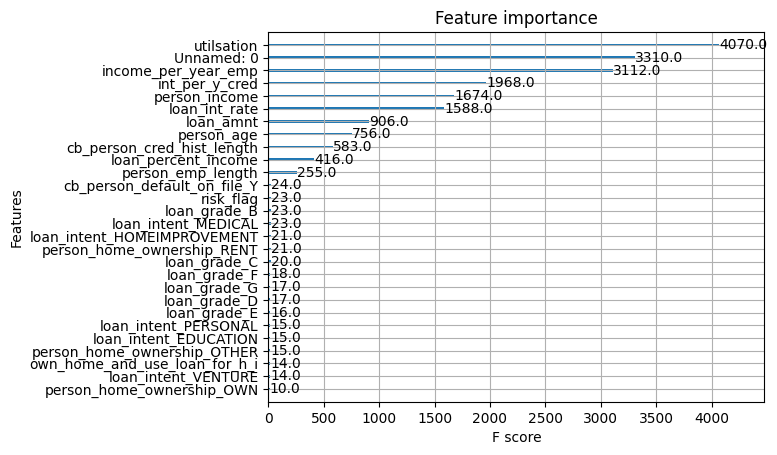

In [34]:
xgb.plot_importance(best_model)
train_data.columns

In [35]:
test_predictions = 0.6*test_predictions_cat_boost + 0.4 *test_predictions_xgboost3
test_predictions_df = pd.DataFrame({"id": test_data["id"], "loan_status" : test_predictions})
test_predictions_df.to_csv("../Data/sample_submission.csv", index = False)